<a href="https://colab.research.google.com/github/Soundflog/MLMedicine/blob/main/computer_vision/COI_Practice_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика 4. Обнаружение и измерение свойств объектов на изображении

## Цель работы:
* Ознакомление с основными этапами обнаружения объектов и измерением их свойств.

## Задания к работе

1. Ознакомиться с основными этапами обнаружения объектов и измерением их свойств.

2. Провести обработку изображений, аналогичную рассмотренной в теории файл для заданного изображения.


# «Разработка специализированной системы для определения степени физического переутомления спортсменов».

In [2]:
#@title Установка зависимостей
!pip -q install mediapipe==0.10.14 opencv-python scikit-image pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [3]:
#@title Импорт модулей и базовые функции
import io, os, math, json, uuid, pathlib
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
from skimage.color import rgb2ycbcr, rgb2hsv
from skimage.filters import sobel_v, gaussian
from skimage.feature import local_binary_pattern
from skimage.exposure import equalize_adapthist

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.grid'] = False

def imshow(img_bgr, title=None):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    if title: plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

def clamp_rect(x0, y0, x1, y1, W, H):
    x0 = max(0, min(W-1, int(x0)))
    y0 = max(0, min(H-1, int(y0)))
    x1 = max(0, min(W-1, int(x1)))
    y1 = max(0, min(H-1, int(y1)))
    if x1 <= x0: x1 = min(W-1, x0+1)
    if y1 <= y0: y1 = min(H-1, y0+1)
    return x0, y0, x1, y1

def rect_from_points(pts):
    xs, ys = zip(*pts)
    return min(xs), min(ys), max(xs), max(ys)

def crop_rect(img, rect):
    x0,y0,x1,y1 = rect
    return img[y0:y1, x0:x1]

def mean_std(arr):
    a = arr.astype(np.float32).ravel()
    return float(np.mean(a)), float(np.std(a))


In [4]:
#@title Инициализация FaceMesh и индексы ключевых точек глаз (MediaPipe)
mp_face = mp.solutions.face_mesh

# Наборы индексов MediaPipe FaceMesh для глаз (век) (стандартные, широко используемые)
LEFT_EYE_IDX = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
RIGHT_EYE_IDX = [263, 249, 390, 373, 374, 380, 381, 382, 362, 398, 384, 385, 386, 387, 388, 466]

# Индексы бровей — для построения опорной зоны лба
LEFT_BROW_IDX = [70, 63, 105, 66, 107]
RIGHT_BROW_IDX = [336, 296, 334, 293, 300]

def landmarks_to_xy(landmarks, w, h):
    pts = []
    for lm in landmarks:
        pts.append((int(lm.x * w), int(lm.y * h)))
    return pts

def select_pts(landmarks, idxs, w, h):
    return [(int(landmarks[i].x*w), int(landmarks[i].y*h)) for i in idxs]

def detect_facemesh(image_bgr):
    with mp_face.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        res = face_mesh.process(img_rgb)
        if not res.multi_face_landmarks:
            return None
        return res.multi_face_landmarks[0]


In [5]:
#@title Функции построения ROI под глазами, лобной и щёчных областей
def eye_bbox(landmarks, eye_idx, W, H, scale_w=1.0, scale_h=1.0):
    pts = select_pts(landmarks, eye_idx, W, H)
    x0,y0,x1,y1 = rect_from_points(pts)
    cx, cy = (x0+x1)/2, (y0+y1)/2
    w = (x1 - x0) * scale_w
    h = (y1 - y0) * scale_h
    x0n, y0n = cx - w/2, cy - h/2
    x1n, y1n = cx + w/2, cy + h/2
    return clamp_rect(x0n, y0n, x1n, y1n, W, H)

def under_eye_rect(eye_rect, H, k_down=0.8, h_scale=0.9):
    # Прямоугольник прямо под глазом: смещаемся вниз на frac высоты глаза и берём высоту ~ frac*высоты глаза
    x0,y0,x1,y1 = eye_rect
    eye_h = (y1 - y0)
    new_y0 = y1 + int(0.2*eye_h)                 # небольшой отступ от нижнего века
    new_y1 = new_y0 + max(1, int(h_scale*eye_h)) # высота области "мешка под глазом"
    return clamp_rect(x0, new_y0, x1, new_y1, W=x1, H=H)  # W передадим отдельно вне функц.

def brow_band_rect(landmarks, W, H, pad_y=0.5):
    # Зона лба: берём брови и поднимаемся выше на долю высоты глаз
    lb = select_pts(landmarks, LEFT_BROW_IDX, W, H)
    rb = select_pts(landmarks, RIGHT_BROW_IDX, W, H)
    x0l,y0l,x1l,y1l = rect_from_points(lb)
    x0r,y0r,x1r,y1r = rect_from_points(rb)
    x0 = min(x0l, x0r); x1 = max(x1l, x1r)
    y_top = min(y0l, y0r)
    # Оценим высоту глазной области через среднюю высоту глаз
    left_eye_h = None; right_eye_h = None
    # при желании можно вычислить точнее, но возьмём эмпирическое смещение
    h_band = int(pad_y * max(10, (y1l - y0l + y1r - y0r)/2))
    y0 = max(0, y_top - (h_band + (y1l - y0l)))
    y1 = max(1, y_top - 2)
    return clamp_rect(x0, y0, x1, y1, W, H)

def cheek_rects(under_eye_left, under_eye_right, H, shift_down=0.5):
    # Щёчные опорные зоны — прямоугольники ниже областей "под глазом"
    def shift(rect):
        x0,y0,x1,y1 = rect
        h = (y1 - y0)
        ny0 = y1 + int(shift_down * h)
        ny1 = ny0 + h
        return x0, max(0, min(H-2, ny0)), x1, max(1, min(H-1, ny1))
    return shift(under_eye_left), shift(under_eye_right)


In [8]:
#@title Функции вычисления метрик
def to_float_rgb(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb.astype(np.float32) / 255.0

def ycbcr_hsv(img_bgr):
    rgb = to_float_rgb(img_bgr)
    ycbcr = rgb2ycbcr(rgb)   # ~видеодиапазон, но как float
    hsv   = rgb2hsv(rgb)     # H,S,V в [0,1]
    Y  = np.clip(ycbcr[...,0], 0, 255).astype(np.float32)
    Cb = np.clip(ycbcr[...,1], 0, 255).astype(np.float32)
    Cr = np.clip(ycbcr[...,2], 0, 255).astype(np.float32)
    H  = hsv[...,0].astype(np.float32)
    S  = hsv[...,1].astype(np.float32)
    V  = hsv[...,2].astype(np.float32)
    return Y, Cb, Cr, H, S, V

def roi_stats(arr, rect):
    x0,y0,x1,y1 = rect
    crop = arr[y0:y1, x0:x1]
    return mean_std(crop), crop

def lbp_stats(gray_roi, P=8, R=1):
    # Local Binary Pattern (uniform=False для простоты), затем энтропия/дисперсия
    lbp = local_binary_pattern(gray_roi, P, R, method='default')
    return float(np.var(lbp)), float(np.mean(lbp)), lbp

def vertical_gradient_strength(gray_roi, sigma=1.0):
    g = gaussian(gray_roi, sigma=sigma, preserve_range=True)
    sob = sobel_v(g.astype(np.float32))
    # Используем медиану и 90-й перцентиль как устойчивые к выбросам показатели
    med = float(np.median(np.abs(sob)))
    p90 = float(np.percentile(np.abs(sob), 90))
    return med, p90


In [25]:
#@title Загрузка изображений
uploaded = files.upload()
img_paths = list(uploaded.keys())
print("Загружены файлы:", img_paths)


Saving 11.JPG to 11.JPG
Загружены файлы: ['11.JPG']


In [26]:
#@title Основной цикл обработки и расчёта метрик
SAVE_DIR = "fatigue_output"
os.makedirs(SAVE_DIR, exist_ok=True)

records = []
failed = []

for path in img_paths:
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        failed.append((path, "cannot read"))
        continue
    H, W = img_bgr.shape[:2]

    lms = detect_facemesh(img_bgr)
    if lms is None:
        failed.append((path, "no face landmarks"))
        continue

    landmarks = lms.landmark

    # Границы глаз
    l_eye_rect = eye_bbox(landmarks, LEFT_EYE_IDX, W, H, scale_w=1.05, scale_h=1.15)
    r_eye_rect = eye_bbox(landmarks, RIGHT_EYE_IDX, W, H, scale_w=1.05, scale_h=1.15)

    # Зоны "под глазами"
    l_under = under_eye_rect(l_eye_rect, H, k_down=0.8, h_scale=0.9)
    r_under = under_eye_rect(r_eye_rect, H, k_down=0.8, h_scale=0.9)

    # Лоб и щёки (опорные зоны для нормализации освещения/цвета)
    brow_rect = brow_band_rect(landmarks, W, H, pad_y=0.6)
    l_cheek_rect, r_cheek_rect = cheek_rects(l_under, r_under, H, shift_down=0.6)

    # Цветовые представления
    Y, Cb, Cr, Hc, S, V = ycbcr_hsv(img_bgr)
    Y8 = cv2.normalize(Y, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # для LBP/градиентов

    # Метрики: средние/СКО по Y, V, Cr (потемнение/краснота); LBP-дисперсия; вертикальный градиент (припухлость)
    # Под глазами (L/R)
    (muY_L, sdY_L), yL = roi_stats(Y, l_under)
    (muY_R, sdY_R), yR = roi_stats(Y, r_under)
    (muV_L, sdV_L), vL = roi_stats(V, l_under)
    (muV_R, sdV_R), vR = roi_stats(V, r_under)
    (muCr_L, sdCr_L), crL = roi_stats(Cr, l_under)
    (muCr_R, sdCr_R), crR = roi_stats(Cr, r_under)

    # Опорные зоны (лоб/щёки)
    (muY_B, sdY_B), _ = roi_stats(Y, brow_rect)
    (muV_B, sdV_B), _ = roi_stats(V, brow_rect)
    (muCr_B, sdCr_B), _ = roi_stats(Cr, brow_rect)

    (muY_LC, _), _ = roi_stats(Y, l_cheek_rect)
    (muY_RC, _), _ = roi_stats(Y, r_cheek_rect)
    (muV_LC, _), _ = roi_stats(V, l_cheek_rect)
    (muV_RC, _), _ = roi_stats(V, r_cheek_rect)
    (muCr_LC, _), _ = roi_stats(Cr, l_cheek_rect)
    (muCr_RC, _), _ = roi_stats(Cr, r_cheek_rect)

    # Нормализованные показатели темноты/яркости (меньше — темнее)
    darkness_L = muY_L / max(1e-6, muY_B)
    darkness_R = muY_R / max(1e-6, muY_B)

    # Разность по яркости V (под глазом относительно щеки и лба): отрицательная — темнее под глазом
    deltaV_L_cheek = muV_L - muV_LC
    deltaV_R_cheek = muV_R - muV_RC
    deltaV_L_brow  = muV_L - muV_B
    deltaV_R_brow  = muV_R - muV_B

    # Краснота/пигментация (Cr выше — «краснее»/темнее по красному каналу)
    deltaCr_L_brow  = muCr_L - muCr_B
    deltaCr_R_brow  = muCr_R - muCr_B
    deltaCr_L_cheek = muCr_L - muCr_LC
    deltaCr_R_cheek = muCr_R - muCr_RC

    # Текстура (LBP-дисперсия) и «припухлость» (вертикальный градиент)
    y8 = Y8
    l_y8 = crop_rect(y8, l_under)
    r_y8 = crop_rect(y8, r_under)
    lbp_var_L, lbp_mean_L, _ = lbp_stats(l_y8, P=8, R=1)
    lbp_var_R, lbp_mean_R, _ = lbp_stats(r_y8, P=8, R=1)
    grad_med_L, grad_p90_L = vertical_gradient_strength(l_y8, sigma=1.0)
    grad_med_R, grad_p90_R = vertical_gradient_strength(r_y8, sigma=1.0)

    # Сводные нормализованные индикаторы (примеры, не диагностика):
    # Чем меньше darkness_* и deltaV_* (отрицательнее), а также больше grad_* и lbp_var — тем выше «подозрение» на утомление по перiorbital.
    # Сформируем эвристический интегральный балл (0..100) для иллюстрации.
    def score_one(dark, dV_brow, dV_cheek, dCr_brow, grad_p90, lbp_var):
        s = 0.0
        s += (1.2 - min(1.2, dark)) * 30.0           # темнее лба
        s += (-min(0.0, dV_brow)) * 40.0             # падение яркости vs лба
        s += (-min(0.0, dV_cheek)) * 15.0            # падение яркости vs щеки
        s += max(0.0, dCr_brow) * 0.15               # краснота/пигментация
        s += grad_p90 * 50.0                         # вертикальные перепады (припухлость)
        s += min(2.0, lbp_var/100.0) * 15.0          # шерховатость/текстура
        return float(np.clip(s, 0, 100))

    score_L = score_one(darkness_L, deltaV_L_brow, deltaV_L_cheek, deltaCr_L_brow, grad_p90_L, lbp_var_L)
    score_R = score_one(darkness_R, deltaV_R_brow, deltaV_R_cheek, deltaCr_R_brow, grad_p90_R, lbp_var_R)
    score_mean = (score_L + score_R) / 2.0

    # Отрисовка ROI
    vis = img_bgr.copy()
    def draw_rect(img, rect, color, label):
        x0,y0,x1,y1 = rect
        cv2.rectangle(img, (x0,y0), (x1,y1), color, 2)
        cv2.putText(img, label, (x0, max(0,y0-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    draw_rect(vis, l_eye_rect, (0,255,255), "L-eye")
    draw_rect(vis, r_eye_rect, (0,255,255), "R-eye")
    draw_rect(vis, l_under,   (0,140,255), "L-under")
    draw_rect(vis, r_under,   (0,140,255), "R-under")
    draw_rect(vis, brow_rect, (255,0,255), "Brow")
    draw_rect(vis, l_cheek_rect, (0,255,0), "L-cheek")
    draw_rect(vis, r_cheek_rect, (0,255,0), "R-cheek")

    out_path = os.path.join(SAVE_DIR, f"overlay_{pathlib.Path(path).stem}.png")
    cv2.imwrite(out_path, vis)

    # Сохранение записей
    rec = dict(
        file=path,
        darkness_L=round(darkness_L, 2),
        darkness_R=round(darkness_R, 2),
        deltaV_L_brow=round(deltaV_L_brow, 2),
        deltaV_R_brow=round(deltaV_R_brow, 2),
        deltaV_L_cheek=round(deltaV_L_cheek, 2),
        deltaV_R_cheek=round(deltaV_R_cheek, 2),
        deltaCr_L_brow=round(deltaCr_L_brow, 2),
        deltaCr_R_brow=round(deltaCr_R_brow, 2),
        deltaCr_L_cheek=round(deltaCr_L_cheek, 2),
        deltaCr_R_cheek=round(deltaCr_R_cheek, 2),
        lbp_var_L=round(lbp_var_L, 2),
        lbp_var_R=round(lbp_var_R, 2),
        grad_med_L=round(grad_med_L, 2),
        grad_med_R=round(grad_med_R, 2),
        grad_p90_L=round(grad_p90_L, 2),
        grad_p90_R=round(grad_p90_R, 2),
        score_L=round(score_L, 2),
        score_R=round(score_R, 2),
        score_mean=round(score_mean, 2),
        overlay=out_path
    )
    records.append(rec)

df = pd.DataFrame.from_records(records)
print("Необработанные файлы (если есть):", failed)
df.head(10)


Необработанные файлы (если есть): []


,file,darkness_L,darkness_R,deltaV_L_brow,deltaV_R_brow,deltaV_L_cheek,deltaV_R_cheek,deltaCr_L_brow,deltaCr_R_brow,deltaCr_L_cheek,...,lbp_var_L,lbp_var_R,grad_med_L,grad_med_R,grad_p90_L,grad_p90_R,score_L,score_R,score_mean,overlay
0,11.JPG,0.73,0.92,-0.19,-0.05,-0.16,-0.18,-1.23,-0.04,-4.14,...,8517.78,7567.3,1.42,3.17,4.28,10.38,100.0,100.0,100.0,fatigue_output/overlay_11.png


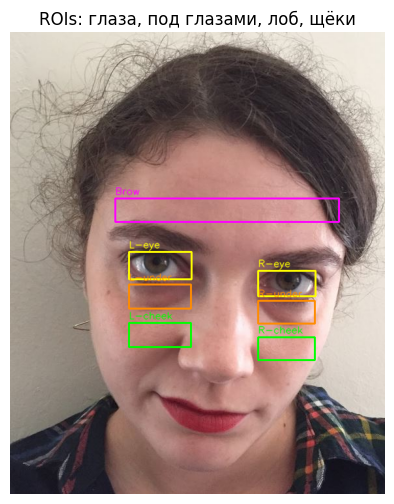

,file,darkness_L,darkness_R,deltaV_L_brow,deltaV_R_brow,deltaV_L_cheek,deltaV_R_cheek,deltaCr_L_brow,deltaCr_R_brow,deltaCr_L_cheek,...,lbp_var_L,lbp_var_R,grad_med_L,grad_med_R,grad_p90_L,grad_p90_R,score_L,score_R,score_mean,overlay
0,11.JPG,0.73,0.92,-0.19,-0.05,-0.16,-0.18,-1.23,-0.04,-4.14,...,8517.78,7567.3,1.42,3.17,4.28,10.38,100.0,100.0,100.0,fatigue_output/overlay_11.png


In [27]:
#@title Просмотр оверлея и таблицы метрик
if len(records):
    imshow(cv2.imread(records[0]['overlay']), title="ROIs: глаза, под глазами, лоб, щёки")
    display(df)
else:
    print("Нет обработанных изображений.")


In [28]:
#@title Сохранить результаты в CSV
csv_path = os.path.join(SAVE_DIR, "fatigue_metrics_women_derivied.csv")
df.to_csv(csv_path, index=False)
print("Сохранено:", csv_path)


Сохранено: fatigue_output/fatigue_metrics_women_derivied.csv


In [22]:
df.head()

,file,darkness_L,darkness_R,deltaV_L_brow,deltaV_R_brow,deltaV_L_cheek,deltaV_R_cheek,deltaCr_L_brow,deltaCr_R_brow,deltaCr_L_cheek,...,lbp_var_L,lbp_var_R,grad_med_L,grad_med_R,grad_p90_L,grad_p90_R,score_L,score_R,score_mean,overlay
0,17.jpg,0.77,0.94,-0.18,-0.02,-0.05,-0.09,-1.48,3.32,-1.68,...,8869.49,8482.74,1.34,1.58,3.57,4.37,100.0,100.0,100.0,fatigue_output/overlay_17.png


In [29]:
#@title Промежуточные изображения: Y/Cr/V, CLAHE, Gaussian, Median, Bilateral, GradV, LBP
import os, pathlib, shutil
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian
from skimage.feature import local_binary_pattern

STAGES_ROOT = "fatigue_stages"
os.makedirs(STAGES_ROOT, exist_ok=True)

def to_uint8(x, scale01=False):
    x = x.astype(np.float32)
    if scale01:
        mn, mx = np.min(x), np.max(x)
        if mx > mn:
            x = (x - mn) / (mx - mn)
        else:
            x = np.zeros_like(x)
        x = (x * 255.0)
    return np.clip(x, 0, 255).astype(np.uint8)

def save_gray(path, arr):
    arr8 = to_uint8(arr, scale01=False)
    cv2.imwrite(path, arr8)

def save_rgb(path, bgr):
    cv2.imwrite(path, bgr)

def under_eye_rect_safe(eye_rect, W, H, offset_frac=0.2, height_frac=0.9):
    x0,y0,x1,y1 = eye_rect
    eye_h = (y1 - y0)
    ny0 = y1 + int(offset_frac * eye_h)
    ny1 = ny0 + max(1, int(height_frac * eye_h))
    return clamp_rect(x0, ny0, x1, ny1, W, H)

def bilateral_gray(u8, d=9, sigma_color=25, sigma_space=9):
    # Bilateral по одноканальному изображению (u8)
    return cv2.bilateralFilter(u8, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)

def sobel_v_abs(u8, sigma=1.0):
    g = gaussian(u8.astype(np.float32), sigma=sigma, preserve_range=True)
    sob = cv2.Sobel(g, cv2.CV_32F, dx=0, dy=1, ksize=3)
    return np.abs(sob)

def lbp_map(u8, P=8, R=1):
    return local_binary_pattern(u8.astype(np.uint8), P, R, method='default')

stage_index_preview = []  # сохраним для предпросмотра

for path in img_paths:
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"[WARN] Не удалось прочитать: {path}")
        continue

    H, W = img_bgr.shape[:2]
    lms = detect_facemesh(img_bgr)
    if lms is None:
        print(f"[WARN] Лицо не найдено: {path}")
        continue
    landmarks = lms.landmark

    # Глаза → ROI «под глазами»
    l_eye_rect = eye_bbox(landmarks, LEFT_EYE_IDX, W, H, scale_w=1.05, scale_h=1.15)
    r_eye_rect = eye_bbox(landmarks, RIGHT_EYE_IDX, W, H, scale_w=1.05, scale_h=1.15)
    l_under = under_eye_rect_safe(l_eye_rect, W, H, 0.2, 0.9)
    r_under = under_eye_rect_safe(r_eye_rect, W, H, 0.2, 0.9)

    # Цветовые представления
    Y, Cb, Cr, Hc, S, V = ycbcr_hsv(img_bgr)
    Y_u8 = to_uint8(Y, scale01=False)
    V_u8 = to_uint8(V*255.0, scale01=False)  # V уже [0..1] → умножаем

    # CLAHE по Y (лицо целиком)
    Y_clahe = equalize_adapthist(Y_u8, clip_limit=0.01)  # float [0..1]
    Y_clahe_u8 = to_uint8(Y_clahe*255.0, scale01=False)

    # Фильтрации по всему лицу (для справки/визуализации)
    Y_gauss_face = gaussian(Y_u8, sigma=1.0, preserve_range=True)
    Y_gauss_face_u8 = to_uint8(Y_gauss_face, scale01=False)
    Y_median_face = cv2.medianBlur(Y_u8, ksize=5)
    Y_bilat_face  = bilateral_gray(Y_u8, d=9, sigma_color=35, sigma_space=11)

    # ROI под левым/правым глазом
    x0L,y0L,x1L,y1L = l_under
    x0R,y0R,x1R,y1R = r_under
    YL = Y_u8[y0L:y1L, x0L:x1L]; VR = V_u8[y0R:y1R, x0R:x1R]  # просто, ниже возьмём нужные каналы

    # Для каждой стороны одинаковый набор стадий
    def roi_stages(u8_roi):
        cla = equalize_adapthist(u8_roi, clip_limit=0.01)
        cla_u8 = to_uint8(cla*255.0, scale01=False)
        g_u8   = to_uint8(gaussian(u8_roi, sigma=1.0, preserve_range=True), scale01=False)
        m_u8   = cv2.medianBlur(u8_roi, 5)
        b_u8   = bilateral_gray(u8_roi, d=9, sigma_color=35, sigma_space=11)
        grad   = to_uint8(sobel_v_abs(u8_roi, sigma=1.0), scale01=True)
        lbp    = lbp_map(u8_roi, P=8, R=1)
        lbp_u8 = to_uint8(lbp, scale01=True)
        return {
            "Y": u8_roi, "Y_CLAHE": cla_u8, "Y_Gauss": g_u8,
            "Y_Median": m_u8, "Y_Bilateral": b_u8,
            "GradV_abs": grad, "LBP": lbp_u8
        }

    Lpack = roi_stages(Y_u8[y0L:y1L, x0L:x1L])
    Rpack = roi_stages(Y_u8[y0R:y1R, x0R:x1R])

    # Оверлей ROI
    vis = img_bgr.copy()
    def draw_rect(img, rect, color, label):
        x0,y0,x1,y1 = rect
        cv2.rectangle(img, (x0,y0), (x1,y1), color, 2)
        cv2.putText(img, label, (x0, max(0,y0-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    draw_rect(vis, l_eye_rect, (0,255,255), "L-eye")
    draw_rect(vis, r_eye_rect, (0,255,255), "R-eye")
    draw_rect(vis, l_under,   (0,140,255), "L-under")
    draw_rect(vis, r_under,   (0,140,255), "R-under")

    # Папка для текущего изображения
    stem = pathlib.Path(path).stem
    OUT = os.path.join(STAGES_ROOT, f"{stem}")
    os.makedirs(OUT, exist_ok=True)

    # Сохранение full-face стадий
    save_rgb(os.path.join(OUT, "01_original_bgr.png"), img_bgr)
    save_gray(os.path.join(OUT, "02_Y.png"), Y_u8)
    save_gray(os.path.join(OUT, "03_V.png"), V_u8)
    save_gray(os.path.join(OUT, "04_Cr.png"), to_uint8(Cr, scale01=False))
    save_gray(os.path.join(OUT, "05_Y_CLAHE.png"), Y_clahe_u8)
    save_gray(os.path.join(OUT, "06_Y_Gauss_face.png"), Y_gauss_face_u8)
    save_gray(os.path.join(OUT, "07_Y_Median_face.png"), Y_median_face)
    save_gray(os.path.join(OUT, "08_Y_Bilateral_face.png"), Y_bilat_face)
    save_rgb(os.path.join(OUT, "09_overlay_ROIs.png"), vis)

    # Сохранение ROI-пакетов
    for name, arr in Lpack.items():
        save_gray(os.path.join(OUT, f"L_under_{name}.png"), arr)
    for name, arr in Rpack.items():
        save_gray(os.path.join(OUT, f"R_under_{name}.png"), arr)

    # Запомним что-нибудь для предпросмотра
    stage_index_preview.append(os.path.join(OUT, "09_overlay_ROIs.png"))

# Архив всего набора
zip_path = shutil.make_archive("fatigue_stages_export", "zip", STAGES_ROOT)
print("Сохранено:", STAGES_ROOT)
print("Архив:", zip_path)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Сохранено: fatigue_stages
Архив: /content/fatigue_stages_export.zip


ROI overlay


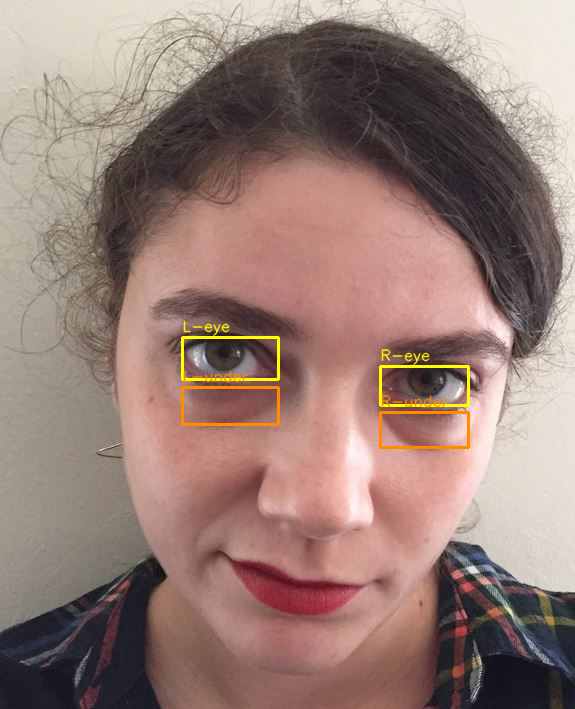

02_Y.png


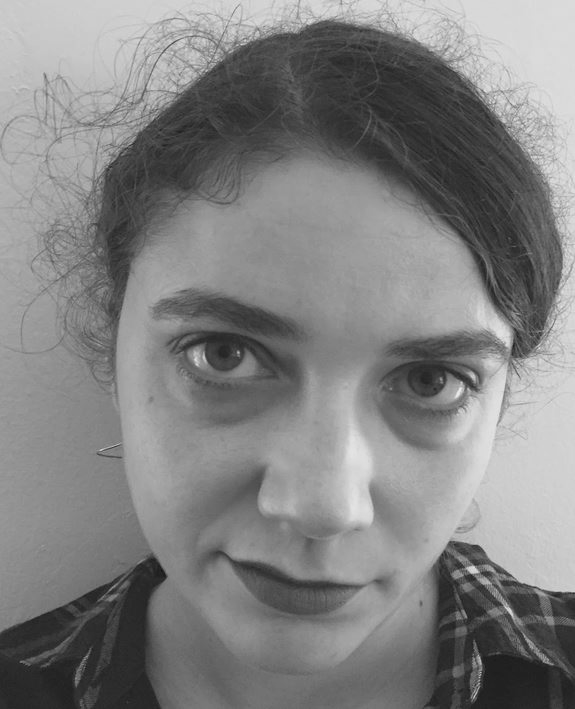

05_Y_CLAHE.png


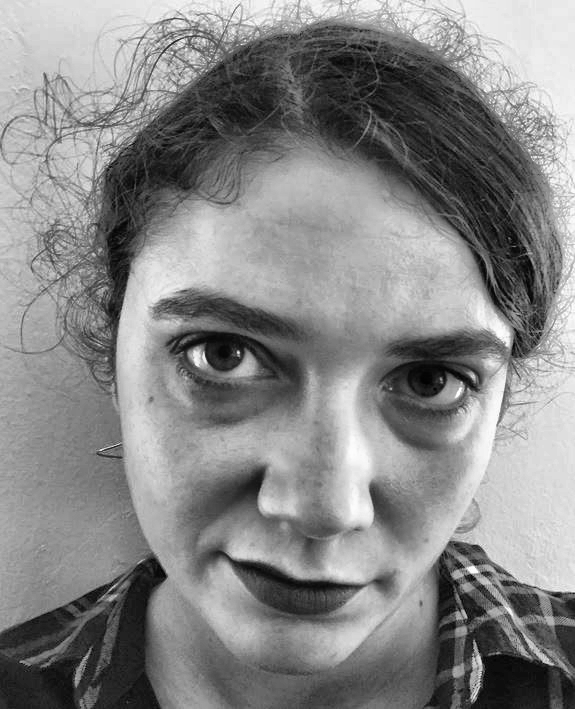

06_Y_Gauss_face.png


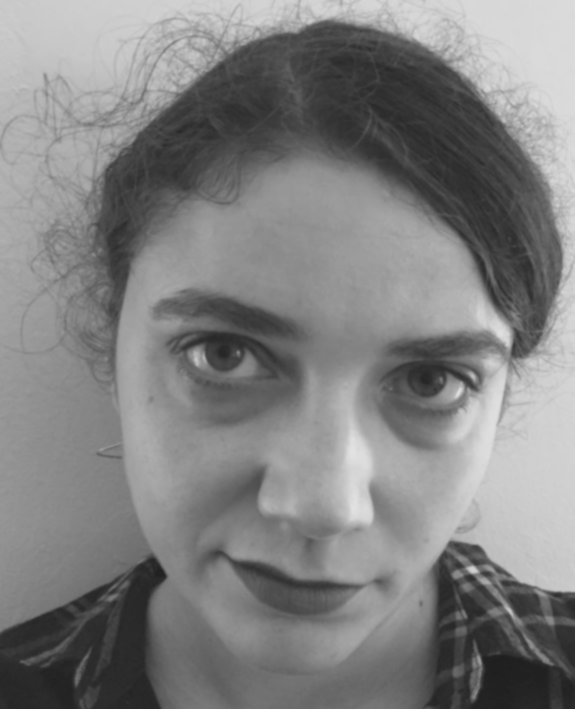

07_Y_Median_face.png


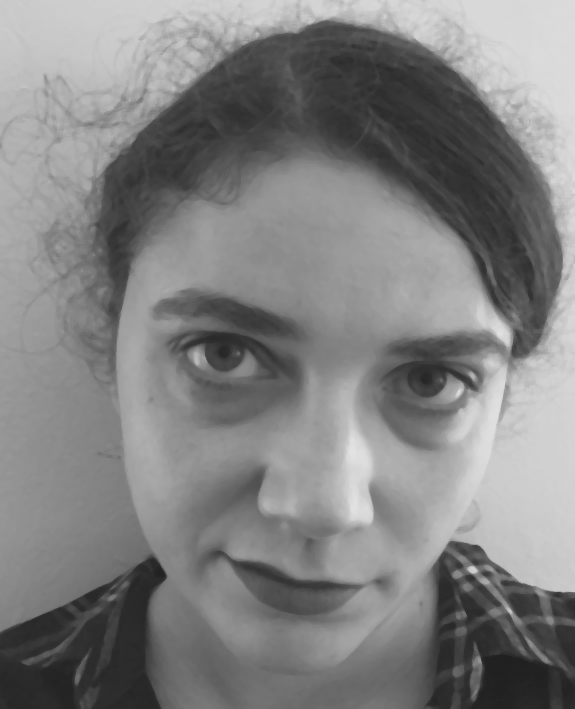

08_Y_Bilateral_face.png


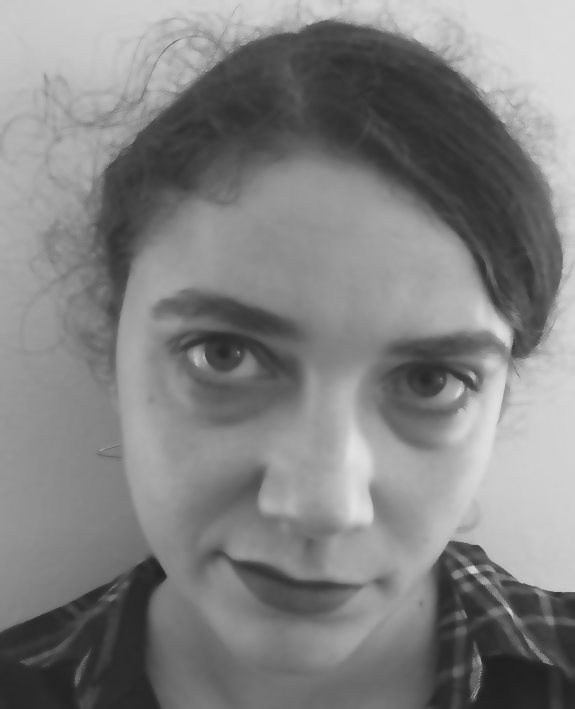

L_under_Y.png


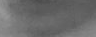

L_under_Y_CLAHE.png


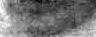

L_under_Y_Gauss.png


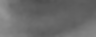

L_under_Y_Median.png


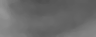

L_under_Y_Bilateral.png


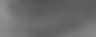

L_under_GradV_abs.png


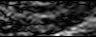

L_under_LBP.png


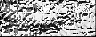

In [30]:
#@title Предпросмотр: оверлеи ROI и ключевые стадии
from IPython.display import Image, display

def show_img(path, title=None):
    if title: print(title)
    display(Image(filename=path))

if stage_index_preview:
    for p in stage_index_preview[:3]:  # первые 3 для примера
        show_img(p, title="ROI overlay")
        base = str(pathlib.Path(p).parent)
        for fn in ["02_Y.png", "05_Y_CLAHE.png", "06_Y_Gauss_face.png", "07_Y_Median_face.png", "08_Y_Bilateral_face.png",
                   "L_under_Y.png", "L_under_Y_CLAHE.png", "L_under_Y_Gauss.png", "L_under_Y_Median.png", "L_under_Y_Bilateral.png",
                   "L_under_GradV_abs.png", "L_under_LBP.png"]:
            fpath = os.path.join(base, fn)
            if os.path.exists(fpath):
                show_img(fpath, title=fn)
else:
    print("Нет сохранённых стадий — проверь входные изображения и детекцию лица.")


/tmp/ipython-input-867015573.py:36: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = square(max(1, morph_kernel))


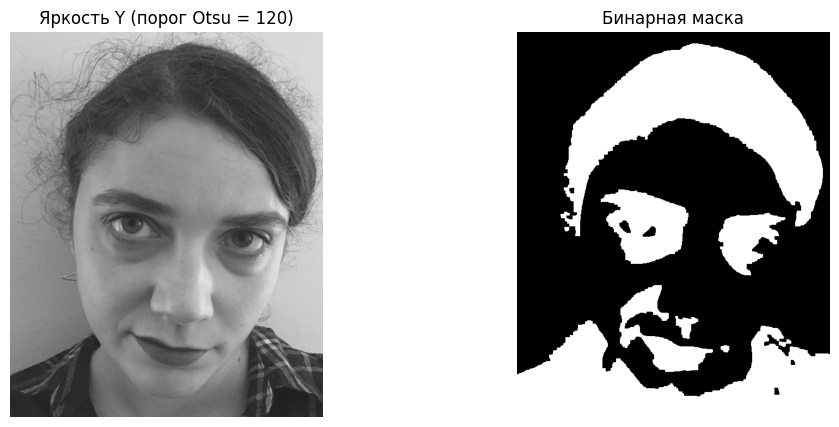

Сохранено: binary_mask.png


In [53]:
#@title Бинарная маска по яркости (Otsu) + очистка морфологией
!pip -q install scikit-image

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2ycbcr
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, opening, closing, square
from google.colab import files

# === Параметры ===
invert_for_dark_objects = True  #@param {type:"boolean"}
min_object_size = 64             #@param {type:"integer"}
min_hole_area   = 64             #@param {type:"integer"}
morph_kernel    = 5              #@param {type:"integer"}

# === Загрузка изображения при отсутствии img_bgr ===
try:
    img_bgr
except NameError:
    uploaded = files.upload()
    fname = next(iter(uploaded.keys()))
    img_bgr = cv2.imread(fname)

# === Яркостная компонента Y из YCbCr ===
rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
Y   = rgb2ycbcr(rgb)[..., 0]                      # float, ~[16..235], но нормализована
Y_u8 = np.clip(Y, 0, 255).astype(np.uint8)

# === Порог Otsu ===
th = threshold_otsu(Y_u8)
mask = (Y_u8 >= th) if not invert_for_dark_objects else (Y_u8 <= th)

# === Постобработка маски (необязательная, но полезная) ===
selem = square(max(1, morph_kernel))
mask = opening(mask, selem)
mask = closing(mask, selem)
mask = remove_small_objects(mask, min_size=max(1, min_object_size))
mask = remove_small_holes(mask, area_threshold=max(1, min_hole_area))

# === Отображение ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title(f"Яркость Y (порог Otsu = {th})"); plt.axis("off"); plt.imshow(Y_u8, cmap="gray", vmin=0, vmax=255)
plt.subplot(1,2,2); plt.title("Бинарная маска"); plt.axis("off"); plt.imshow(mask, cmap="gray")
plt.show()

# Сохранение при необходимости
cv2.imwrite("binary_mask.png", (mask.astype(np.uint8) * 255))
print("Сохранено: binary_mask.png")


Найдено объектов: 8


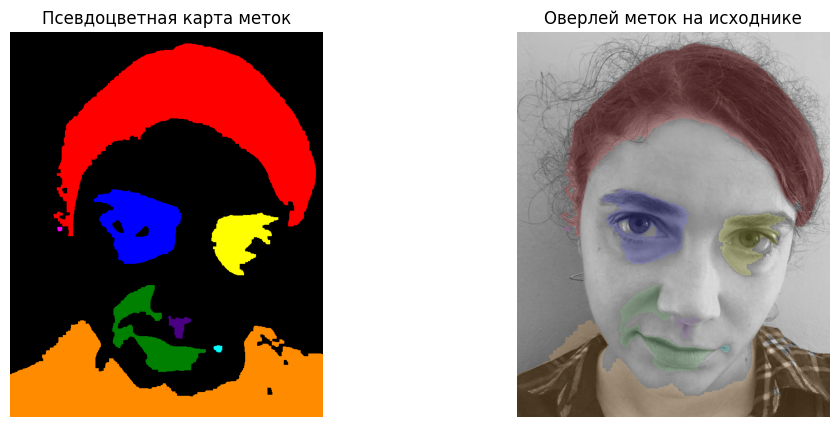

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1
0,1,68650.0,21,80,376,562,158.958820,336.493926
1,2,14045.0,290,154,427,315,355.574938,238.186757
2,3,7870.0,333,370,448,493,380.452605,420.695299
3,4,66.0,359,87,367,96,362.242424,91.015152
4,5,9291.0,466,188,626,360,558.386503,259.904854


Сохранено: labels_pseudocolor.png, labels_overlay.png, labels_properties.csv


In [54]:
#@title Метки связных компонент и псевдоцветная карта
from skimage.measure import label, regionprops_table
from skimage.color import label2rgb
import pandas as pd

connectivity = 2          #@param {type:"integer"}  # 1 — 4-связность, 2 — 8-связность
overlay_alpha = 0.15      #@param {type:"number"}

# === Маркировка связных компонент ===
labels = label(mask, connectivity=connectivity, background=0)
n_labels = int(labels.max())
print(f"Найдено объектов: {n_labels}")

# === Псевдоцвет без подложки и оверлей на исходник ===
pseudo_plain = label2rgb(labels, bg_label=0)  # чистая псевдоцветная карта
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
pseudo_overlay = label2rgb(labels, image=img_rgb, bg_label=0, alpha=overlay_alpha, kind='overlay')

# === Отображение ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Псевдоцветная карта меток"); plt.axis("off"); plt.imshow(pseudo_plain)
plt.subplot(1,2,2); plt.title("Оверлей меток на исходнике"); plt.axis("off"); plt.imshow(pseudo_overlay)
plt.show()

# === Таблица свойств объектов (пример) ===
props = regionprops_table(labels, properties=("label","area","bbox","centroid"))
df = pd.DataFrame(props)
display(df.head())

# === Сохранение ===
import imageio.v2 as imageio
imageio.imwrite("labels_pseudocolor.png", (pseudo_plain*255).astype(np.uint8))
imageio.imwrite("labels_overlay.png", (pseudo_overlay*255).astype(np.uint8))
df.to_csv("labels_properties.csv", index=False)
print("Сохранено: labels_pseudocolor.png, labels_overlay.png, labels_properties.csv")
